# Workflow 4

### Import est_lib Functions

In [1]:
from est_lib.util.obspy_util import *
from est_lib.util.obspy_plot import ray_plot

### Some Other Functions Used in This Workflow

In [2]:
import os
from obspy import UTCDateTime as dt
from tqdm.notebook import tqdm

### Specify Search Parameters

In [3]:
station_list = ['BFSB','CBB','CLRS','HOLB','HOPB','LLLB','NLLB'
                ,'NTKA','PACB','PHC','PTRF','SNB','SYMB','VGZ','WOSB']
channel_list = ['HNE','HNN','HNZ']

# Note: channel_list specifies the channels of interest
#    In this example, we retrieve velocity data for 
#    all three directions (E, N and Z). To get acceleration
#    data replace with ['HNE','HNN','HNZ']

'''
Specify a Time of interest. Note that that the timestamp
is in UTC.
'''
event_time = "2018-10-22T06:22:45"
event_lat = 49.051
event_lon = -129.8831
event = ('6.5',event_lat,event_lon,event_time)

### Retrieve Station Metadata

In [4]:
'''
Use the inventory_retriever function to retrieve
metadata about stations in station_list
'''
station_metadata = inventory_retriever(sta_list=station_list)

In [5]:
print(station_metadata)

Inventory created at 2021-08-06T01:53:48.000000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.47
		    http://service.iris.edu/fdsnws/station/1/query?network=CN&station=B...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			CN
		Stations (15):
			CN.BFSB (Boischatel, QC, CA)
			CN.CBB (Campbell River, BC, CA)
			CN.CLRS (Cowichan Lake Research St, BC, CA)
			CN.HOLB (Holberg, BC, CA)
			CN.HOPB (Hope, BC, CA)
			CN.LLLB (Lillooet, BC, CA)
			CN.NLLB (Nanaimo Lost Lake, BC, CA)
			CN.NTKA (Nootka, BC, CA)
			CN.PACB (Port Alice, BC, CA)
			CN.PHC (Port Hardy, BC, CA)
			CN.PTRF (Port Renfrew PTRF, BC, CA)
			CN.SNB (Saturna Island, BC, CA)
			CN.SYMB (Survey Mountain, BC, CA)
			CN.VGZ (Victoria Gonzales, BC, CA)
			CN.WOSB (Woss, BC, CA)
		Channels (253):
			CN.BFSB..HHZ (2x), CN.BFSB..HHN (2x), CN.BFSB..HHE (2x), 
			CN.BFSB..HNZ (2x), CN.BFSB..HNN (2x), CN.BFSB..HNE (2x), 
			CN.CBB..BHZ (5x), CN.CBB..BHN (5x), CN.CBB..BHE (5x), CN.CBB..HHZ, 
			

### Retrieve Seismic Streams

In [6]:
'''
Use the stream_retriever function to retrieve
seismic streams from an IRIS' FDSN compliant
datacenter.

We instruct the function to fetch data starting
from 500 seconds before the specified time upto
150 seconds after.

That is, if the time of interest is at 0, we
fetch data from -500 to 150.
'''

seconds_before = 500
seconds_after = 1500

data = stream_retriever(event_time=event_time,
                        time_format='string',
                        seconds_before = 500,
                        seconds_after = 1500,
                        sta_list = station_list,
                        channel_list = channel_list)

In [7]:
print(data)

33 Trace(s) in Stream:

CN.BFSB..HNE | 2018-10-22T06:14:25.000000Z - 2018-10-22T06:39:25.000000Z | 100.0 Hz, 150001 samples
...
(31 other traces)
...
CN.VGZ..HNZ | 2018-10-22T06:14:25.000000Z - 2018-10-22T06:39:25.000000Z | 100.0 Hz, 150001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


### Extract Seismic Waveforms as Text Files

The data we are interested in is stored within the Stream object. Let us extract all of that (excluding the metadata) into individual .dat files (one per station).

All outputs will be stored in a directory called 'Data' in the current working directory.

#### Specify Output Directory

In [8]:
'''
Specify a destination directory where outputs get stored.
'''
#test_name = "demo-file-retriever".format(str(dt.now()).replace(':','.'))
filepath = os.path.abspath(os.path.join('./Data'))
if(not os.path.isdir(filepath)):
    os.mkdir(filepath)

In [9]:
print(filepath)

C:\Users\aksha\Desktop\eew-spatio-temporal\workflow_demos\Data


#### Clean Up - Check for Blanks in Stream Object

Occassionaly there can be incomplete records within the Stream object. Check and eliminate blank records.

In [10]:
# Filter Station List to retain Stations with Trace Data
temp_station_list = station_list.copy()
count = 0
with open(os.path.join(filepath,"trace_metadata.txt"),'w') as f:
    for i,sta in enumerate(temp_station_list):
        score = 0
        for j,cha in enumerate(channel_list):
            temp = data.select(station=sta,channel=cha)
            try:
                f.write('{}\n'.format(temp[0]))
                count+=1
            except(IndexError):
                score+=1
        if score > 0:
            station_list.remove(sta)

print("Count = {}".format(count))
print(station_list)
print(len(station_list))

Count = 33
['BFSB', 'CBB', 'HOLB', 'HOPB', 'NLLB', 'PACB', 'PHC', 'PTRF', 'SNB', 'SYMB', 'VGZ']
11


#### Filter the Data to Remove Noise

In [11]:
'''
Uses a bandpass filter with cutoff frequencies 0.01 Hz and 4 Hz
'''
data.filter(type='bandpass',freqmin=0.01,freqmax=4)

33 Trace(s) in Stream:

CN.BFSB..HNE | 2018-10-22T06:14:25.000000Z - 2018-10-22T06:39:25.000000Z | 100.0 Hz, 150001 samples
...
(31 other traces)
...
CN.VGZ..HNZ | 2018-10-22T06:14:25.000000Z - 2018-10-22T06:39:25.000000Z | 100.0 Hz, 150001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

#### Remove the Frequency Response of the Seismic Sensor

In [12]:
data.remove_response(inventory=station_metadata)

33 Trace(s) in Stream:

CN.BFSB..HNE | 2018-10-22T06:14:25.000000Z - 2018-10-22T06:39:25.000000Z | 100.0 Hz, 150001 samples
...
(31 other traces)
...
CN.VGZ..HNZ | 2018-10-22T06:14:25.000000Z - 2018-10-22T06:39:25.000000Z | 100.0 Hz, 150001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

#### Visualize the Seismic Event

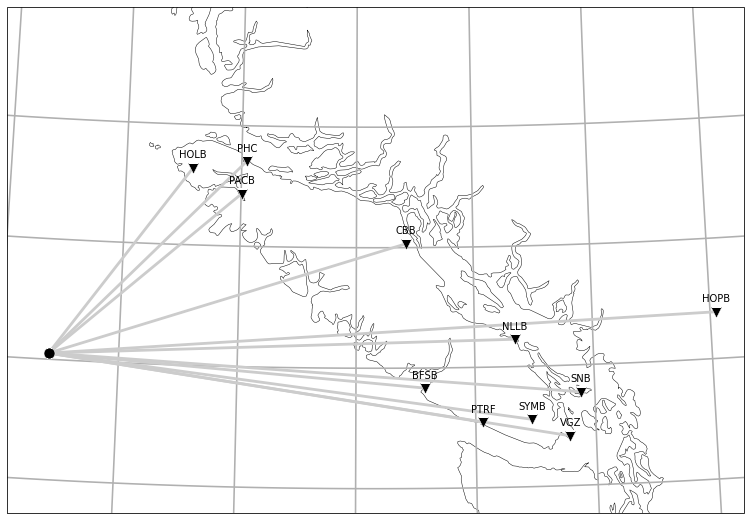

In [13]:
ev_fig = ray_plot(
    ev_lat=event_lat,
    ev_lon=event_lon,
    min_lat=47.8,
    max_lat=52.,
    min_lon=-130.5,
    max_lon=-121,
    streams=data,
    inventory=station_metadata)

#### Functions to Extract out Metadata and Create Additional Files

Let us also extract some of the metadata so that whoever uses the numpy array can make sense of the data.

In [14]:
# Metadata Printer
def dump_meta(inv,sta_list,f_path):
    with open(f_path,'w') as f:
        f.write("Station\t\tLatitude\tLongitude\n")
        f.write("=======\t\t========\t=========")
        for sta in sta_list:
            temp = inv.select(station=sta)
            station = temp[0][0]
            f.write("\n{}\t\t{}\t\t{}".format(station.code,station.latitude,station.longitude))
        f.write("\n")
            
def dump_event_meta(ev,sb,sa,f_path):
    start = str(dt(ev[3])-sb)
    end = str(dt(start)+sa)
    with open(f_path,'w') as f:
        f.write("Magnitude\tLatitude\tLongitude\tTrace-Start (UTC)\t\tTrace-End (UTC)\n")
        f.write("==========\t========\t=========\t=================\t\t===============\n")
        f.write("{}\t\t{}\t\t{}\t{}\t{}".format(ev[0],ev[1],ev[2],start,end))
        f.write("\n")

##### 1. Station Codes and their Locations

In [15]:
dump_meta(station_metadata,station_list,
          os.path.join(filepath,'station_metadata.txt'))
with open(os.path.join(filepath,'station_metadata.txt'),'r') as f:
    print(f.read())

Station		Latitude	Longitude
=======		========	=========
BFSB		48.8336		-125.136
CBB		50.0315		-125.3652
HOLB		50.6402		-128.1331
HOPB		49.3872		-121.4206
NLLB		49.2271		-123.9882
PACB		50.4355		-127.4925
PHC		50.7067		-127.433
PTRF		48.5442		-124.4131
SNB		48.7751		-123.1723
SYMB		48.5593		-123.7989
VGZ		48.4131		-123.3251



##### 2. Metadata Related to the Event

In [16]:
dump_event_meta(event,seconds_before,seconds_after,
                os.path.join(filepath,'event_metadata.txt'))
with open(os.path.join(filepath,'event_metadata.txt'),'r') as f:
    print(f.read())

Magnitude	Latitude	Longitude	Trace-Start (UTC)		Trace-End (UTC)
==========	========	=========	=================		===============
6.5		49.051		-129.8831	2018-10-22T06:14:25.000000Z	2018-10-22T06:39:25.000000Z



##### 3. Write Data Out into Custom Format

This is just a custom data format where the first 5 lines of the file will consist of some metadata. Following this, each row is a 1x3 triaxial seismic sample where the columns are Vertical, North-South and East-West channels.

Sample,

```
Station_code    BFSB
Sampling_rate   100.0
Start_date      2018.10.22
Start_time      06:14:25
Vertical (m/s^2)        North (m/s^2)           East (m/s^2)
-0.0010685019082619699  -0.003461954835698028   -0.003578377100121772
-0.0010677304483372137  -0.00345945613336081    -0.003575795889378532
-0.001066962096388213   -0.003456967495819506   -0.0035732250824874385
-0.0010661982534927097  -0.003454493459941072   -0.003570669368776998
-0.001065442255987208   -0.0034520448319277745  -0.003568139917266109
```

In [17]:
def demo_data_writer(streams,f_path,sta_list,cha_list):
    for s,sta in tqdm(enumerate(sta_list)):
        temp = streams.select(station=sta)
        # file_management
        f_dest = os.path.join(f_path,'{}.dat'.format(sta))
        with open(f_dest,'w') as f:
            # header
            assert sta == temp[0].stats.station
            f.write("Station_code\t{}\n".format(temp[0].stats.station))
            f.write("Sampling_rate\t{}\n".format(temp[0].stats.sampling_rate))
            f.write("Start_date\t{}\n".format(str(temp[0].stats.starttime.date).replace('-','.')))
            f.write("Start_time\t{}\n".format(temp[0].stats.starttime.time))
            f.write("Vertical (m/s^2)\tNorth (m/s^2)\t\tEast (m/s^2)\n")
            for i,(ud,ns,ew) in enumerate(zip(temp[2],temp[1],temp[0])):
                f.write("{}\t{}\t{}\n".format(ud,ns,ew))

In [18]:
demo_data_writer(data,filepath,station_list,channel_list)

0it [00:00, ?it/s]

##### 4. Verification

Now that we've written out the data, let's execute some code to make sure that the data is sane and has been written out correctly.

The following function reads in a .dat file.

In [29]:
'''
This method reads the .dat file we created and stores (in memory) just
the numerical waveform data.
'''

def demo_data_reader(f_path):
    op = np.genfromtxt(f_path,skip_header=5)
    return op

The next piece of code compares the data in each .dat file with what was retrieved using est_lib.

In [30]:
# Check if all Data is Packed Correctly
for i,sta in tqdm(enumerate(station_list)):
    comp = demo_data_reader(os.path.join(filepath,'{}.dat'.format(sta)))
    count_down = 2
    for j,cha in enumerate(channel_list):
        temp = data.select(station=sta,channel=cha)
        assert np.all(np.equal(temp[0].data,comp[:,count_down - j]))

0it [00:00, ?it/s]

##### 5. Visual Verification

Plot out a portion of data from the Stream object and the corresponding data from the last section to make a visual comparison.

In [31]:
import matplotlib.pyplot as plt

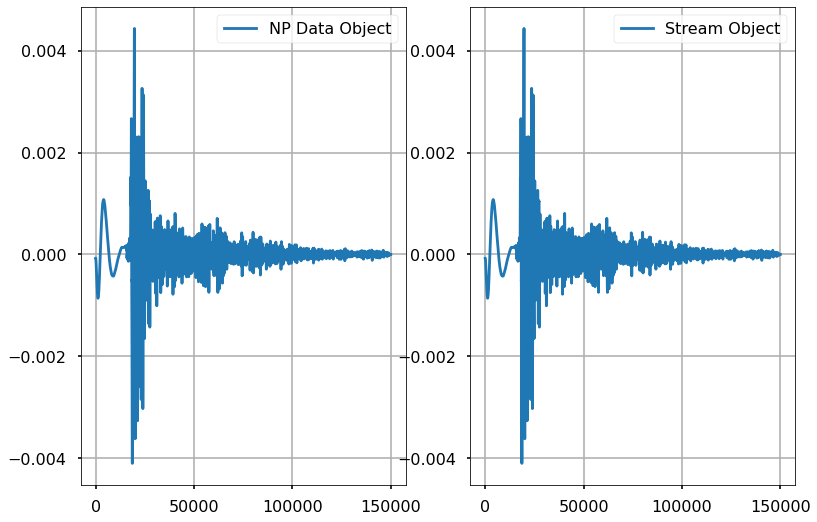

In [32]:
# Plot to Verify
# 7th Stream (2,0) --> CN.HOPB..HNE | 2018-10-22T06:12:45.000000Z - 2018-10-22T06:42:45.000000Z | 100.0 Hz, 180001 samples
# CN.HOLB..HNE | 2018-10-22T06:12:45.000000Z - 2018-10-22T06:37:45.000000Z | 100.0 Hz, 150001 samples
samp  = demo_data_reader(os.path.join(filepath,'HOLB.dat'))

plt.figure()
plt.subplot(1,2,1)
plt.plot(samp[:,2],label='NP Data Object')
plt.legend()
plt.grid()
plt.subplot(1,2,2)
plt.plot(data[6],label='Stream Object')
plt.legend()
plt.grid()
plt.show()